# **Prepared data for Analysis**

## Imported data and loaded in dataframe

In [1358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [1359]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Created a map of the area

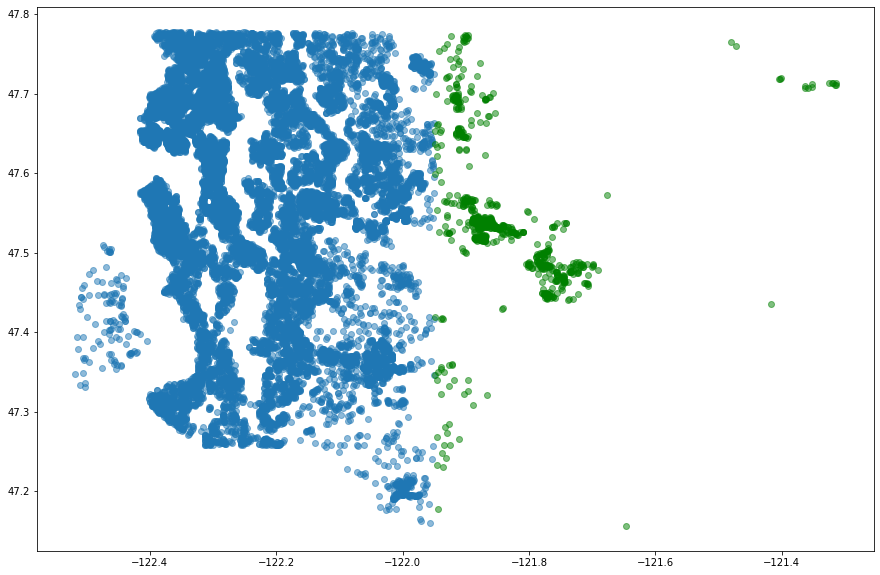

In [1360]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x='long', y='lat', data=df_seattle, alpha=.5)
ax.scatter(x='long', y='lat', data=df_country, alpha=.5, c='green');

# **Creating new variables**

## Added Age and Cleaned Columns

In [1361]:
df = all_data.drop(['view', 'zipcode', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

In [1362]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [1363]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [1364]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [1365]:
df['yr_renovated/built'] = df['yr_built']

In [1366]:
df['age'] = df['date'] - df['yr_renovated/built']

In [1367]:
df.drop(['yr_renovated','yr_built', 'date'], axis=1, inplace=True)

## One-Hot Encoded Basement

In [1368]:
df['sqft_basement'] = df['sqft_basement'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].str.replace('?', '0')
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['has_basement'] = [int(x) for x in df['sqft_basement'] > 0]
df = df.drop('sqft_basement', axis=1)

## Created new groups for region, and made DataFrames for country and Seattle Areas

In [1369]:
df['region'] = [int(x) for x in all_data['long'] > -121.95]

In [1370]:
df_country = df.loc[df['region']==1]
df_seattle = df.loc[df['region']==0]

# **Test model to determine worthwile variables**

In [1371]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
y = df['price']
model_1 = sm.OLS(Y, X)
results = model_1.fit()

In [1372]:
X = df[['sqft_living', 'floors', 'grade', 'age']]

In [1373]:
residuals = results.resid

In [1374]:
preds = results.predict()

# **Making a Function to check assumptions**

## Function that ties it all together

In [1375]:
def check_model(model, X, y):
    results = model.fit()
    residuals = results.resid
    preds = results.predict()
        
    display(rainbow(results), vif(X), heteroskd(preds, y), norm_resids(residuals))
           

## Function for Varience Inflection Factor

In [1376]:
def vif(X_data):
    rows = X_data.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(X_data.columns))]
    vif_df["feature"] = X_data.columns
    return vif_df

## Function of Normality of Residuals

In [1377]:
def norm_resids(residuals):
    figureqq = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45');

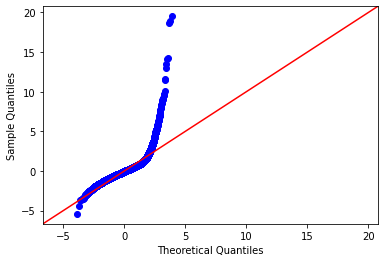

In [1378]:
norm_resids(residuals)

## Function of Heteroskedascicity and Auto Correlation

In [1379]:
def heteroskd (preds, Y):
    resids = preds - Y
    figure = sns.regplot(preds, resids, color='red', 
                       line_kws={'color':'blue'}, 
                       scatter_kws={'alpha':.5});
    return figure

>>>>>>> remote
<<<<<<< local <unchanged>


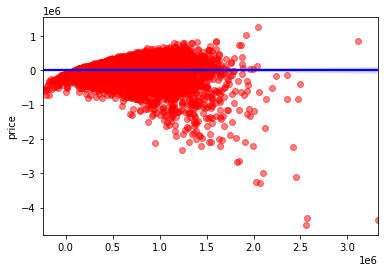

<<<<<<< local <removed>


>>>>>>> remote <removed>


>>>>>>> remote <modified: >


In [1380]:
heteroskd(preds, Y);

## Function for Linear Rainbow Test

In [1381]:
def rainbow(results):
    fstat, pvalue = sm.stats.diagnostic.linear_rainbow(results)
    return f'P-value of linearity: {pvalue}'

In [1382]:
rainbow(results)

'P-value of linearity: 2.467415663044872e-09'

## Function for idenfying outliers and number of outliers

In [1383]:
def outliers(df, column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    return lower_lim, upper_lim

In [1384]:
def outlier_count(column):
    high_o = (df[column] > outliers(column)[1]).sum()
    low_o = (df[column] < outliers(column)[0]).sum()
    return high_o, low_o

In [1385]:
outliers(df_country, 'sqft_living')

(-295.0, 4645.0)

<<<<<<< local
>>>>>>> remote
<<<<<<< local <unchanged>
>>>>>>> remote
>>>>>>> remote <removed>
<<<<<<< local <removed>


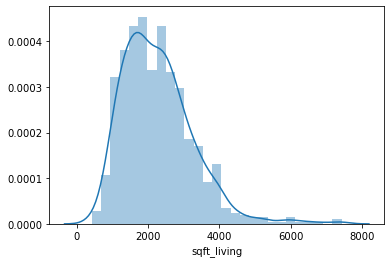

<<<<<<< local <removed>


<<<<<<< local
>>>>>>> remote <modified: text/plain>


>>>>>>> remote <modified: >


<<<<<<< local <removed>


>>>>>>> remote
>>>>>>> remote <removed>


>>>>>>> remote <modified: >


In [1386]:
sns.distplot(df_country['sqft_living'])

# **Models for Seattle and Country Areas**

## Model Creation

In [1387]:
X_seattle1 = sm.add_constant(df_seattle[['sqft_living','grade','age', 'bathrooms']])
y_seattle1 = df_seattle['price']

X_country1 = sm.add_constant(df_country[['sqft_living','grade','age', 'bathrooms']])
y_country1 = df_country['price']

base_model_seattle = sm.OLS(y_seattle1, X_seattle1)
base_model_country = sm.OLS(y_country1, X_country1)

test_results_seattle = base_model_seattle.fit()
test_results_country = base_model_country.fit()

## Checking Assumptions

'P-value of linearity: 0.8629425388523382'

,VIF,feature
0,94.128933,const
1,3.972789,sqft_living
2,3.164854,grade
3,1.927620,age
4,3.784014,bathrooms


>>>>>>> remote
<<<<<<< local <unchanged>
>>>>>>> remote <removed>
<<<<<<< local <removed>


None

<<<<<<< local <removed>


<<<<<<< local


>>>>>>> remote <modified: >


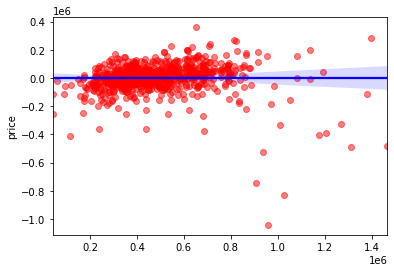

<<<<<<< local


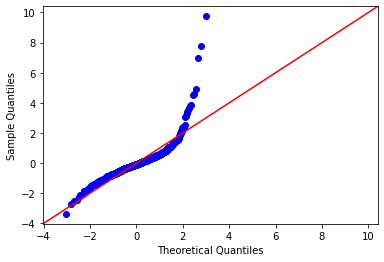

>>>>>>> remote
<<<<<<< local <unchanged>
>>>>>>> remote
>>>>>>> remote <removed>


>>>>>>> remote


>>>>>>> remote


<<<<<<< local <unchanged>


>>>>>>> remote


>>>>>>> remote <removed>


In [1388]:
check_model(base_model_country, X_country1, y_country1)

'P-value of linearity: 3.8883487918457116e-10'

,VIF,feature
0,93.229857,const
1,3.460169,sqft_living
2,2.719283,grade
3,1.478610,age
4,2.853604,bathrooms


None

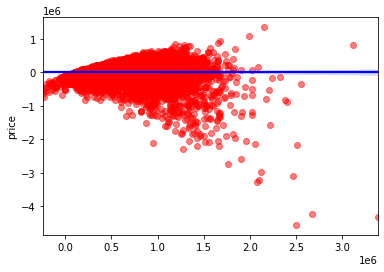

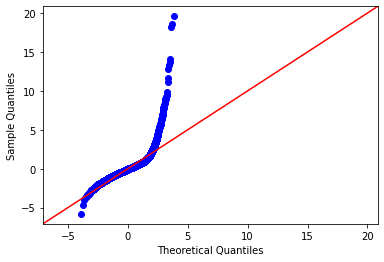

In [1389]:
check_model(base_model_seattle, X_seattle1, y_seattle1)

# **Creating more specific data**

## Function for dropping outliers

In [1390]:
def df_no_outliers(data, column):
    outlier_low = (data[column] < outliers(data, column)[0])
    outlier_high = (data[column] > outliers(data, column)[1])
    return data[column][~(outlier_low | outlier_high)]

## Creating new dataframes without outliers

In [1391]:
df_seattle_no_outliers = df_seattle

In [1392]:
df_seattle_no_outliers['bathrooms'] = df_no_outliers(df_seattle, 'bathrooms')
df_seattle_no_outliers['sqft_living'] = df_no_outliers(df_seattle, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_seattle_no_outliers['waterfront'] = df_seattle_no_outliers.waterfront.fillna(0)
df_seattle_no_outliers = df_seattle_no_outliers.dropna()

In [1393]:
df_country_no_outliers = df_country

In [1394]:
df_country_no_outliers['bathrooms'] = df_no_outliers(df_country, 'bathrooms')
df_country_no_outliers['sqft_living'] = df_no_outliers(df_country, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_country_no_outliers['waterfront'] = df_country_no_outliers.waterfront.fillna(0)
df_country_no_outliers = df_country_no_outliers.dropna()

In [1395]:
df_seattle_no_outliers['sqft_open'] = df_seattle_no_outliers['sqft_lot'] - df_seattle_no_outliers['sqft_living']

In [1396]:
df_country_no_outliers['sqft_open'] = df_country_no_outliers['sqft_lot'] - df_country_no_outliers['sqft_living']

## Assessing correlation and creating "bedroom_num"

In [1397]:
df_seattle_no_outliers.corr()['price'].map(abs).sort_values()

>>>>>>> remote
<<<<<<< local <unchanged>


id                    0.002237
age                   0.013327
yr_renovated/built    0.013522
long                  0.038108
sqft_open             0.050990
condition             0.060438
sqft_lot              0.065370
renovated             0.126094
has_basement          0.168332
waterfront            0.207567
floors                0.244064
bedrooms              0.270212
lat                   0.374016
bathrooms             0.445819
sqft_living           0.625752
grade                 0.634509
price                 1.000000
region                     NaN
Name: price, dtype: float64

In [1398]:
df_country_no_outliers.corr()['price'].map(abs).sort_values()

>>>>>>> remote
<<<<<<< local <unchanged>


lat                   0.007891
id                    0.028015
renovated             0.074444
has_basement          0.081868
condition             0.160495
long                  0.250033
sqft_open             0.260690
sqft_lot              0.267637
bedrooms              0.468197
age                   0.483628
yr_renovated/built    0.484745
floors                0.492898
bathrooms             0.670663
grade                 0.735302
sqft_living           0.840379
price                 1.000000
waterfront                 NaN
region                     NaN
Name: price, dtype: float64

>>>>>>> remote <removed>
<<<<<<< local <removed>


In [1399]:
df_country_no_outliers['bathroom_num'] = df_country_no_outliers['bathrooms']*df_country_no_outliers['bedrooms']
df_seattle_no_outliers['bathroom_num'] = df_seattle_no_outliers['bathrooms']*df_seattle_no_outliers['bedrooms']

# **Our Finished Models!**

## Model Creation and Summary

In [1441]:
X_seattle = sm.add_constant(df_seattle_no_outliers[['sqft_living', 'grade', 'waterfront', 'has_basement', 'bathrooms']])
y_seattle = np.log(df_seattle_no_outliers['price'])
seattle_model = sm.OLS(y_seattle, X_seattle)
seattle_results = seattle_model.fit()

In [1422]:
X_country = sm.add_constant(df_country_no_outliers[['sqft_living','grade', 'sqft_open' ]])
y_country = df_country_no_outliers['price']
country_model = sm.OLS(y_country, X_country)
country_results = country_model.fit()

In [1442]:
seattle_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     4241.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        10:58:51   Log-Likelihood:                -7105.1
No. Observations:               20159   AIC:                         1.422e+04
Df Residuals:                   20153   BIC:                         1.427e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.0701      0.020    558.532      0.000      11.031      11.109
sqft_living      0.0002   5.39e-06     39.620      0.000       0.000       0.000
grade            0.2028      0.003     59.460      0.000       0.196       0.210
waterfront       0.6232      0.033     18.977      0.000       0.559       0.688
has_basement     0.1304      0.005     25.267      0.000       0.120       0.141
bathrooms       -0.0334      0.005     -6.531      0.000      -0.043      -0.023
==============================================================================
Omnibus:                       16.791   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.380
Skew:                           0.056   Prob(JB):                     0.000277
Kurtosis:                       2.916   Cond. No.                     2.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1424]:
country_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     795.7
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          1.80e-225
Time:                        10:56:20   Log-Likelihood:                -8865.2
No. Observations:                 707   AIC:                         1.774e+04
Df Residuals:                     703   BIC:                         1.776e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.37e+05    2.4e+04     -5.711      0.000   -1.84e+05   -8.99e+04
sqft_living   114.5910      4.679     24.491      0.000     105.405     123.777
grade        4.367e+04   3965.942     11.012      0.000    3.59e+04    5.15e+04
sqft_open       0.2569      0.029      8.984      0.000       0.201       0.313
==============================================================================
Omnibus:                       47.940   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.432
Skew:                           0.156   Prob(JB):                     6.60e-40
Kurtosis:                       5.455   Cond. No.                     9.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking Assumptions for model

'P-value of linearity: 0.998536567598279'

,VIF,feature
0,67.712656,const
1,2.763497,sqft_living
2,2.197338,grade
3,1.074495,has_basement
4,1.003772,waterfront
5,2.114746,bathrooms


<<<<<<< local <removed>


<<<<<<< local <removed>


>>>>>>> remote <modified: >


<<<<<<< local <removed>


<<<<<<< local
>>>>>>> remote <modified: text/plain>


>>>>>>> remote <modified: >


None

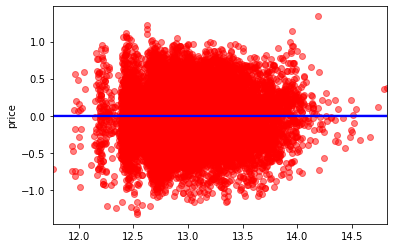

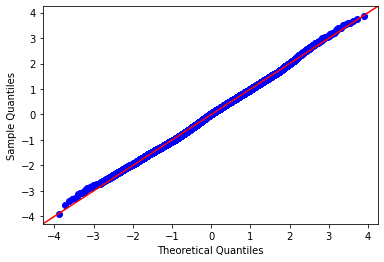

<<<<<<< local <removed>


>>>>>>> remote
>>>>>>> remote <removed>


>>>>>>> remote <modified: >


In [1337]:
check_model(seattle_model, X_seattle, y_seattle)

>>>>>>> remote
<<<<<<< local <unchanged>


'P-value of linearity: 0.9554586904146475'

>>>>>>> remote <removed>
<<<<<<< local <removed>


<<<<<<< local <removed>


>>>>>>> remote <modified: text/plain>
<<<<<<< local


>>>>>>> remote <modified: >


>>>>>>> remote
<<<<<<< local <unchanged>


,VIF,feature
0,88.680519,const
1,1.994746,sqft_living
2,1.994746,grade


>>>>>>> remote <removed>
<<<<<<< local <removed>


<<<<<<< local <removed>


>>>>>>> remote <modified: text/html, text/plain>
<<<<<<< local


>>>>>>> remote <modified: >


>>>>>>> remote
<<<<<<< local <unchanged>
>>>>>>> remote <removed>
<<<<<<< local <removed>


None

>>>>>>> remote
<<<<<<< local <unchanged>


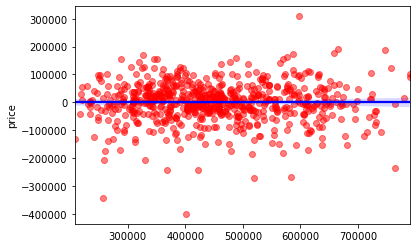

<<<<<<< local <removed>


>>>>>>> remote <removed>


>>>>>>> remote <modified: >


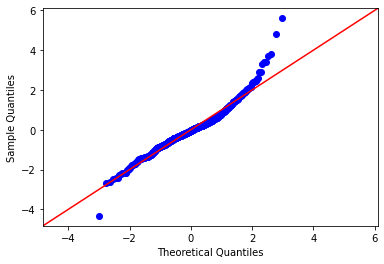

In [1407]:
check_model(country_model, X_country, y_country)

# **Creating Visuals**

## Bar Plot for grade and mean price

In [1338]:
test = pd.DataFrame(df_seattle_no_outliers.groupby('grade').mean()['price'])
test['index'] = range(10)
test.set_index('index', inplace=True)
test['grade'] = [3,4,5,6,7,8,9,10,11,12]

,price,grade
index,,
0,2.620000e+05,3
1,2.166978e+05,4
2,2.460917e+05,5
3,3.022770e+05,6
4,4.026612e+05,7
5,5.415461e+05,8
6,7.647284e+05,9
7,9.850874e+05,10
8,1.172618e+06,11


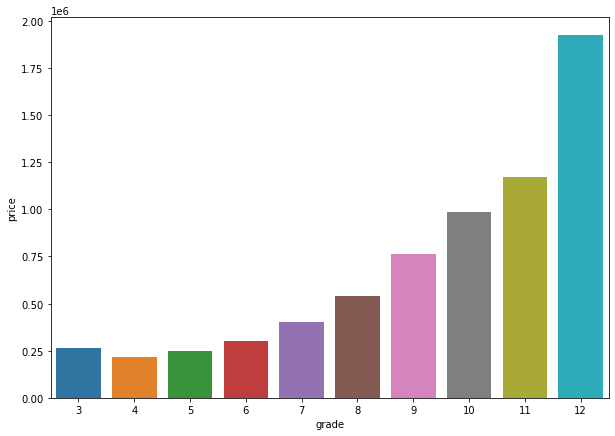

In [1247]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data = test, x='grade', y='price');

# **Reports**

## Seattle Model Report

#### Overview
Our model using data from within the city of Seattle was created to infer how potential factors affected the selling prices of homes within that specified area. By modeling multiple independent variables in relation to price, we narrowed down the truly significant factors to be the house's square footage (sqft_living), the number of bathrooms per bedroom (bathrooms), whether it had a basement or not (has_basement),  whether it had a waterfront view or not (waterfront), and the overall grade of the house as defined by the King County grading system (grade). The goal of our model was to provide an accurate change in sales price in respect to changing each one of those variables.
- Note: sqft_living correspondes with the square footage of the structure, not the square footage of the lot or property

The pricing of the homes was log-transformed to more cleanly fit with our model. By doing so, it passed the assumptions neccesary for providing inference. 

#### Interpreting the Model
The coefficients associated with our model represent the proportion at which the sales price changes, given that the independent variable increased by 1 unit. 

The coefficient for sqft_living is **0.0002**, which means for every 1 sqft increase in house area, the price of that home goes up by 0.02%. While this may seem small, square footage increases multiplicitly rate when expanding the length and width of a house; adding 10 feet to the width and 10 feet to the length of a house results in 100 additional sqft. 

The coefficient for grade is **0.2039**. This means that increasing the grade of the house by 1 increases the price by roughly 20.4%.

The coefficient for ratio of bathrooms is **-0.0342**. This means that by increasing the ratio of bathrooms to bedrooms by 1, the price *decreases* by 3.42%. For example, if you have 2 bathrooms for every bedroom, and increase that number to 3 bathrooms per bedroom, you will lower the value of the home.

The coefficient for has_basement is **0.1303**. This means that adding a basement to your home would increase the price by 13.03%.

The coefficient for waterfront is **0.6208**. This means that by having a waterfront view, the value of your home goes up by 62.08%.
- While adding a waterfront view is impossible for some homes, this metric applies to houses with *potential* waterfront views that do not utilize them. If you have a veiw of the water that is blocked, it would behoove you to remove that obstruction.

# Creating more depth with Seattle Model